In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [3]:
smiling_faces=['cropped_file0011', 'cropped_file0052', 'cropped_file0075', 'cropped_file0659', 'cropped_file0841']
nonsmiling_faces = ['cropped_file3162', 'cropped_file3306', 'cropped_file3434', 'cropped_file3429', 'cropped_file3489']

In [8]:
def convert_to_np(files_list, size=(100, 100)):
    for file_name in files_list:
        img_path = f'./data/genki4k/files/cropped_faces2/{file_name}.png'
        current_image = image.load_img(img_path, target_size = size, 
                                       color_mode = 'grayscale')
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [9]:
smiling_faces = convert_to_np(smiling_faces)
nonsmiling_faces = convert_to_np(nonsmiling_faces)

In [11]:
def find_mean_img(full_mat, title, size = (100, 100)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

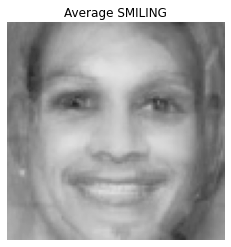

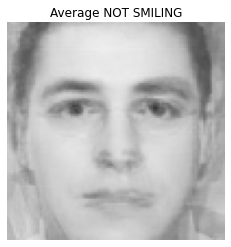

In [12]:
smiling_mean = find_mean_img(smiling_faces, 'SMILING')
nonsmiling_mean = find_mean_img(nonsmiling_faces, 'NOT SMILING')

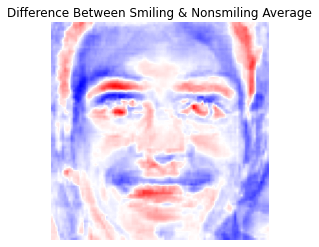

In [13]:
contrast_mean = smiling_mean - nonsmiling_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Smiling & Nonsmiling Average')
plt.axis('off')
plt.show()

Number of PC:  3


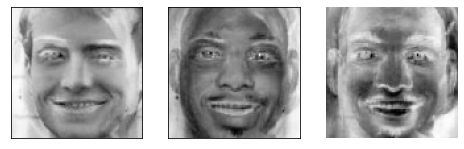

Number of PC:  2


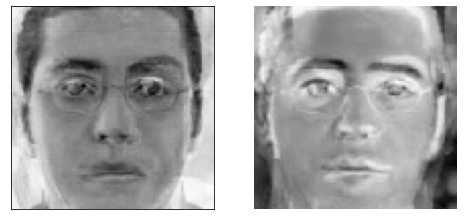

In [14]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (100, 100)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (100, 100)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(smiling_faces, 'SMILING'))
plot_pca(eigenimages(nonsmiling_faces, 'NON SMILING'))

In [15]:
from cProfile import label
import cv2
from PIL import Image
import time

In [20]:
def get_labels(labels_path):
    labels = np.zeros(4000)
    # label data
    label_file = open(labels_path, "r")
    for i, label in enumerate(label_file):
        labels[i] = label.split()[0]
    label_file.close()
    
    failed_to_crop = [15, 18, 30, 39, 64, 81, 82, 86, 114, 125, 182, 207, 208, 216, 217, 241, 261, 264, 281, 295, 319, 330, 334, 352, 353, 354, 398, 399, 404, 410, 434, 437, 444, 453, 454, 466, 506, 540, 544, 549, 553, 587, 669, 672, 674, 675, 688, 694, 701, 703, 707, 710, 739, 752, 777, 782, 786, 822, 825, 829, 858, 873, 880, 881, 930, 941, 995, 1018, 1038, 1067, 1068, 1082, 1086, 1096, 1100, 1120, 1136, 1179, 1247, 1270, 1272, 1292, 1303, 1312, 1318, 1351, 1355, 1367, 1402, 1403, 1429, 1474, 1497, 1499, 1500, 1506, 1508, 1515, 1543, 1562, 1568, 1569, 1574, 1580, 1582, 1591, 1613, 1621, 1645, 1646, 1654, 1666, 1684, 1690, 1726, 1749, 1759, 1760, 1761, 1765, 1767, 1776, 1777, 1797, 1808, 1812, 1819, 1861, 1872, 1879, 1887, 1899, 1923, 1937, 1945, 1947, 1958, 1970, 1978, 1992, 2006, 2024, 2046, 2064, 2081, 2110, 2111, 2131, 2147, 2169, 2177, 2190, 2195, 2199, 2205, 2210, 2211, 2233, 2261, 2267, 2268, 2307, 2314, 2322, 2326, 2329, 2343, 2344, 2361, 2386, 2394, 2398, 2421, 2423, 2461, 2471, 2472, 2485, 2490, 2502, 2508, 2510, 2515, 2530, 2543, 2585, 2599, 2602, 2609, 2640, 2651, 2660, 2671, 2705, 2743, 2752, 2761, 2771, 2773, 2805, 2807, 2821, 2826, 2830, 2838, 2841, 2845, 2863, 2870, 2871, 2892, 2893, 2927, 2974, 2989, 2993, 3019, 3026, 3091, 3148, 3160, 3164, 3170, 3198, 3212, 3214, 3271, 3275, 3321, 3348, 3393, 3401, 3410, 3411, 3415, 3416, 3430, 3471, 3480, 3481, 3508, 3511, 3522, 3527, 3553, 3554, 3558, 3567, 3569, 3580, 3586, 3587, 3629, 3643, 3646, 3654, 3662, 3664, 3666, 3671, 3676, 3677, 3679, 3702, 3705, 3792, 3793, 3808, 3811, 3815, 3816, 3817, 3837, 3851, 3861, 3884, 3890, 3899, 3900, 3902, 3921, 3932, 3946, 3949, 3950, 3971, 3973, 3978, 3987, 3989]
    labels = np.delete(labels, failed_to_crop)

    return labels

<BarContainer object of 2 artists>

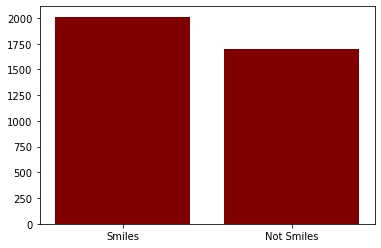

In [21]:
labels_dir = './data/genki4k/labels.txt'
    
labels = get_labels(labels_dir)

smiles_data = {'Smiles': list(labels).count(1), 'Not Smiles':list(labels).count(0)}
plt.bar(smiles_data.keys(), smiles_data.values(), color='maroon')